# Introducción

*Preliminares*
La ecuación de Schrödinger en el espacio de configuración es, probablemente, una de las ecuaciones que más información nos pueden dar sobre el mundo microscópico. Como toda ecuación diferencial, sólo se conocen soluciones exactas para los potenciales más sencillos. Cuando queremos considerar sistemas más elaborados hay dos sopas: usar métodos perturbativos y aproximaciones por series de potencias, o usar métodos numéricos. 

Este problema consiste en resolver la ecuación diferencial de segundo orden
$$
\left(-\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x) \right)\psi(x) = E \psi(x)
$$

donde $V(x)$ es el potencial al que está sometida la partícula y $|\psi(x)|^2$ la probabilidad de encontrarla en la posición $x$.

*Método de numerov*
El método de Numerov es un método *marchante* que, a pesar de ser relativamente fácil de implementar, puede arrojar resultados muy cercanos a la realidad.

Para derivarlo, expandimos en serie de Taylor la versión discretizada de $\psi$:
$$\psi(x_{\pm 1})=\psi(x_0) \pm \psi'(x_0) \Delta + \frac{1}{2!}\psi''(x_0)
\Delta^2 \pm \frac{1}{3!}\psi'''(x_0) \Delta^3 + \frac{1}{4!}\psi''''(x_0)
\Delta^4 \pm \frac{1}{5!}\psi'''''(x_0) \Delta^5 + \mathcal{O}(\Delta^6)$$

Si sumamos estos compas, tenemos que las potencias impares se nos van:
$$\psi(x_{+ 1})+\psi(x_{- 1}) =2\psi(x_0)  + \psi''(x_0)
\Delta^2 + \frac{1}{12}\psi''''(x_0)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Para encontrar el cuadrado del operador central, tomamos la expresión dada y le
volvemos a aplicar $\delta$:

$$\delta(\delta(g))= g(x+\Delta)-g(x) - (g(x) - g(x-\Delta)) $$

Si le aplicamos esta chulada a $\psi$, tenemos que:

$$\delta^2(\psi_n) = \psi_{n+1}  + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\psi''''(x_n)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Ahora vemos cómo se vería la cuarta derivada como función de la segunda
derivada:

$$\delta^2(\psi''_n) = \psi''_{n+1} + \psi''_{n-1} - 2\psi''_n  = \psi''''(x_0)
\Delta^2 + \mathcal{O}(\Delta^4)$$ y lo enchufamos en la expresión anterior:

$$\delta^2(\psi_n) = \psi_{n+1} + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\delta^2(\psi''(x_n))
\Delta^2 + \mathcal{O}(\Delta^6)$$

Ahora, la dizque ecuación de Chóringa nos dice que $\psi''(x)=f(x)\psi(x)$, que
en lenguaje discreto se ve como $\psi''_n=f_n\psi_n$. Podemos usar esto en la
ecuación anterior para cambiar poner a todas las segundas derivadas en función
de $\psi$:
$$ \psi_{n+1}+\psi_{n-1} - 2\psi_n  = f_{n}\psi_{n}
\Delta^2 + \frac{1}{12}(f_{n+1}\psi_{n+1} + f_{n-1}\psi_{n-1} - 2f_{n}\psi_{n})
\Delta^2 + \mathcal{O}(\Delta^6)$$

Ahora bien, si pasamos los $f_i\psi_i$, del lado izquierdo, se tiene que

$$ \psi_{n+1}\left(1 - \frac{\Delta^2 }{12}\right) - \psi_{n-1}\left(1 - \frac{\Delta^2 }{12}\right) - 2\psi_n\left(1 - \frac{\Delta^2 }{12}\right)  = f_{n}\psi_{n}
\Delta^2 + \mathcal{O}(\Delta^6)$$ que con la función propuesta toma la forma 

$$ \phi_{n+1} + \phi_{n-1}- 2\phi_n  = f_{n}\psi_{n}
\Delta^2 $$ 

O bien,
$$ \phi_{n+1} =  2\phi_n - \phi_{n-1}  + f_{n}\psi_{n}
\Delta^2 $$ 

Si $n=0$, término que trae $n-1$ nos va a causar problemas. Supongo que a este
método hay que darle dos puntitos iniciales para que empiece a trabajar y saque
cosas interesantes.

# Método del disparo

In [1]:
using PyPlot

INFO: Loading help data...


# Método de igualación

In [1]:
N = 100

100

In [2]:
x = zeros(N)

100-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [3]:
dx=1e-2

0.01

In [6]:
V = Float64[]

0-element Array{Float64,1}

In [8]:
for x in -1:dx:1
    push!(V,x^2)
end

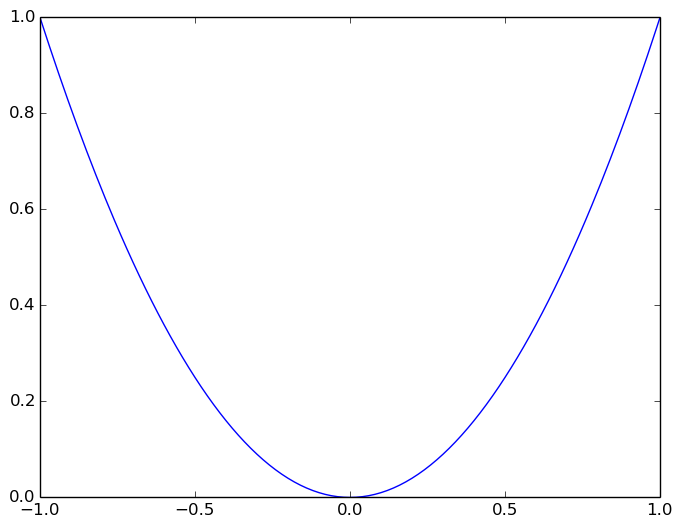

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5260799ed0>

In [206]:
x = [-1:dx:1]
plot(x,V)

In [10]:
using PyPlot

INFO: Loading help data...


In [16]:
E=1/2+1/25

0.54

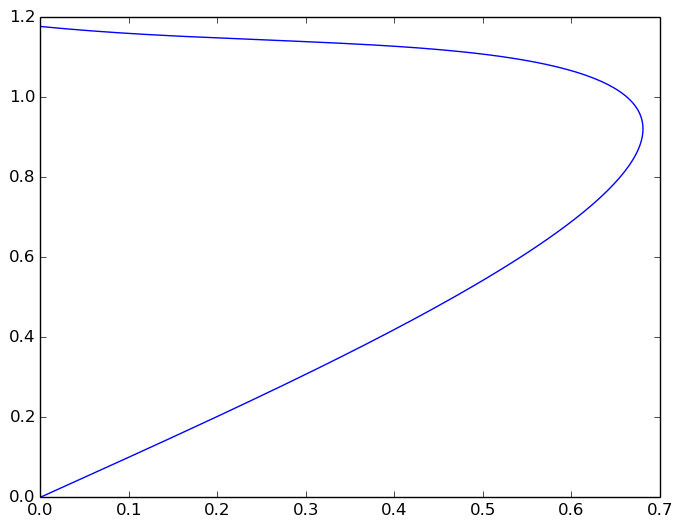

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f52604b2b10>

In [205]:
plot(x,Ψl)

In [41]:
using Interact

In [44]:
Ψl = zeros(V)
Ψl[1] = 0
Ψl[2] = dx

0.01

In [45]:
for i in 2:length(V) - 1
    Ψl[i+1] = 2Ψl[i] - Ψl[i-1] - 2*(dx)^2*(E-V[i])*Ψl[i]
end

In [46]:
Ψr = zeros(V)
Ψr[end] = 0
Ψr[end-1] = dx

0.01

In [47]:
for i in reverse(2:length(V) - 1)
    Ψr[i-1] = 2Ψr[i] - Ψr[i+1] - 2*(dx)^2*(E-V[i])*Ψr[i]
end

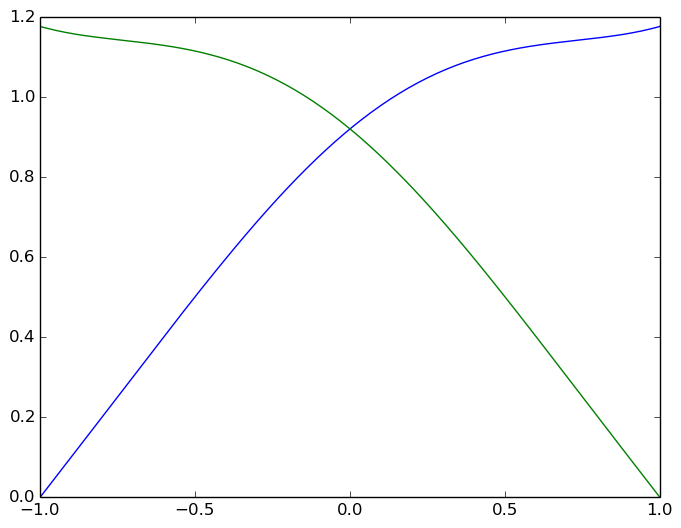

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5261251910>

In [48]:
plot(x,Ψl)
plot(x,Ψr)

In [78]:
function devolver(E)
    Ψl = zeros(V)
    Ψl[1] = 0
    Ψl[2] = dx
    Ψr = zeros(V)
    Ψr[end] = 0
    Ψr[end-1] = dx
    for i in 2:length(V) - 1
        Ψl[i+1] = 2Ψl[i] - Ψl[i-1] - 2*(dx)^2*(E-V[i])*Ψl[i]
    end
    for i in reverse(2:length(V) - 1)
        Ψr[i-1] = 2Ψr[i] - Ψr[i+1] - 2*(dx)^2*(E-V[i])*Ψr[i]
    end
    Ψl, Ψr
end

devolver (generic function with 1 method)

In [209]:
x1,y1 = devolver(1.36204)

([0.0,0.01,0.0199992,0.0299969,0.039992,0.0499835,0.0599705,0.0699518,0.0799261,0.0898921  …  0.0898962,0.0799302,0.0699559,0.0599747,0.0499877,0.0399962,0.0300011,0.0200035,0.0100043,4.27887e-6],[4.27887e-6,0.0100043,0.0200035,0.0300011,0.0399962,0.0499877,0.0599747,0.0699559,0.0799302,0.0898962  …  0.0898921,0.0799261,0.0699518,0.0599705,0.0499835,0.039992,0.0299969,0.0199992,0.01,0.0])

Emparejamiento en un punto

In [137]:
x[101]

0.6807706742767895

In [138]:
y[101]

0.6807706742767895

Emparejamiento en un punto de las __derivadas__

In [210]:
a = (x1[101]-x1[100])/dx

0.00927573061340059

In [211]:
b = (y1[101]-y1[100])/dx

0.009269445434001433

In [191]:
abs(a-b)<1e100

true

In [194]:
a-b

6.285179399156959e-6

In [199]:
a-b< 1e-6

false

In [203]:
function psis(E)
    Ψl = zeros(V)
    Ψl[1] = 0
    Ψl[2] = dx
    Ψr = zeros(V)
    Ψr[end] = 0
    Ψr[end-1] = dx
    for i in 2:length(V) - 1
        Ψl[i+1] = 2Ψl[i] - Ψl[i-1] - 2*(dx)^2*(E-V[i])*Ψl[i]
    end
    for i in reverse(2:length(V) - 1)
        Ψr[i-1] = 2Ψr[i] - Ψr[i+1] - 2*(dx)^2*(E-V[i])*Ψr[i]
    end
    plot(x,Ψl)
    plot(x,Ψr)
end

psis (generic function with 1 method)

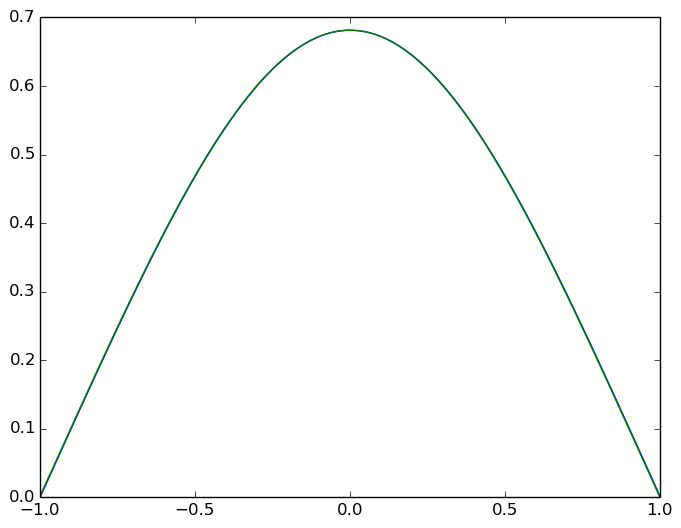

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f526093b9d0>

In [207]:
psis(1.36)

In [75]:
length(V)

201

In [77]:
V[101]

0.0

In [72]:
sqrt(2)

1.4142135623730951

Slider{Float64}([Input{Float64}] 7.8,"E",7.8,0.6:0.01:15.0)

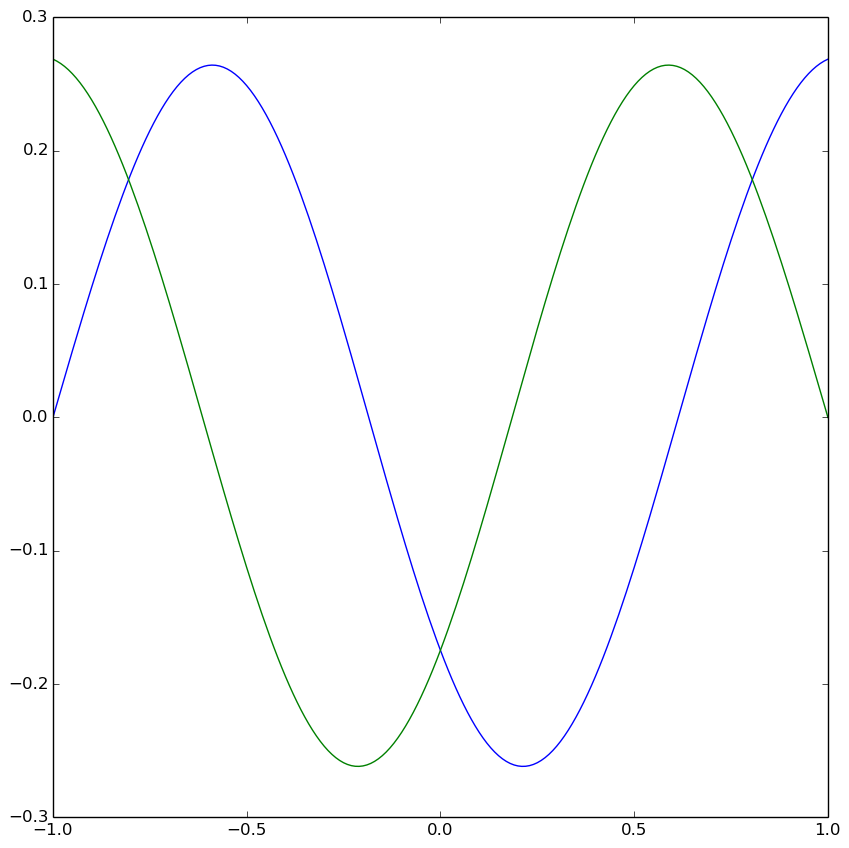

In [208]:
fig = figure(figsize=(10,10))

@manipulate for E in .6:.01:15.
    withfig(fig) do
        psis(E)
    end
end